## Testing ECMWF 9-Point Wind Grid System

Comparing the 9-grid system derived from the ECMWF data to the original NCEP grid. Using 2015 as a data subset.

In [15]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from windrose import WindroseAxes
import numpy as np
import pandas as pd
import cartopy.feature as cfeature
import cartopy

import sys
sys.path.append('../')
import functions as f

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'meteorological_data'

site_coords = [53.3267, -9.9046]

#### Extracting Data

##### Original Data

In [2]:
ncep_original = xr.open_mfdataset((data_path/'NCEP'/"ncep_original").glob("*2015.nc"))
ecmwf_original = xr.open_mfdataset((data_path/'ECMWF'/'MHD'/'single_levels').glob("*2015*.nc"))

c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


##### Grids

In [3]:
ecmwf_ds = xr.open_mfdataset((data_path/'ECMWF'/'MHD'/'10m_wind_grid').glob('*2015.nc'))
ncep_ds = xr.open_mfdataset((data_path/'NCEP'/"wind_9points").glob("*2015.nc")).sel(dict(site='MHD', level=10))

# checking latitude and longitude are the same for both datasets
tolerance = 1e-3
for n in range(0,8):
    ecmwf_latitude = ecmwf_ds['latitude'].values[n]
    ncep_latitude = ncep_ds['lat'].values[n]

    ecmwf_longitude = ecmwf_ds['longitude'].values[n] + 360
    ncep_longitude = ncep_ds['lon'].values[n]

    assert np.abs(ecmwf_latitude - ncep_latitude) <= tolerance, f"Points {n} are not almost equal. {ncep_latitude} != {ecmwf_latitude}"
    assert np.abs(ecmwf_longitude - ncep_longitude) <= tolerance, f"Points {n} are not almost equal. {ncep_longitude} != {ecmwf_longitude}"

In [4]:
ecmwf_u = ecmwf_ds['u10']
ecmwf_v = ecmwf_ds['v10']

ncep_u = ncep_ds['uwnd']
ncep_v = ncep_ds['vwnd']

In [5]:
ecmwf_wind_speed = np.sqrt(ecmwf_u**2 + ecmwf_v**2)
ecmwf_wind_direction = (np.arctan2(ecmwf_u, ecmwf_v) * 180 / np.pi) + 180

ncep_wind_speed = np.sqrt(ncep_u**2 + ncep_v**2)
ncep_wind_direction = (np.arctan2(ncep_u, ncep_v) * 180 / np.pi) + 180

#### Windrose

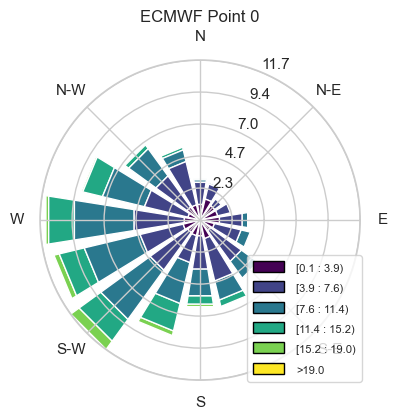

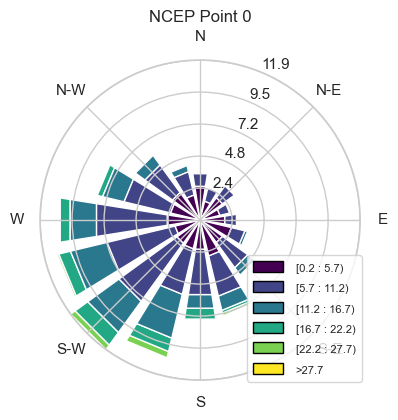

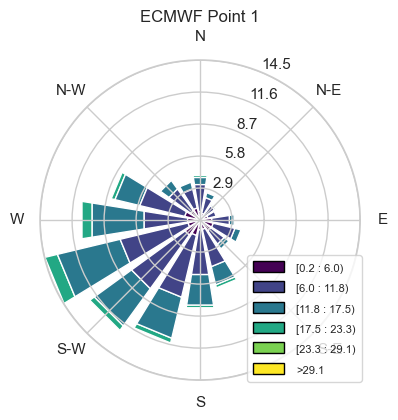

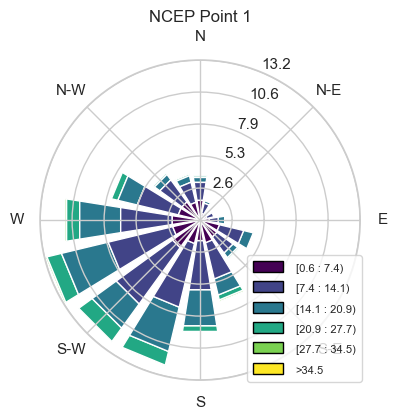

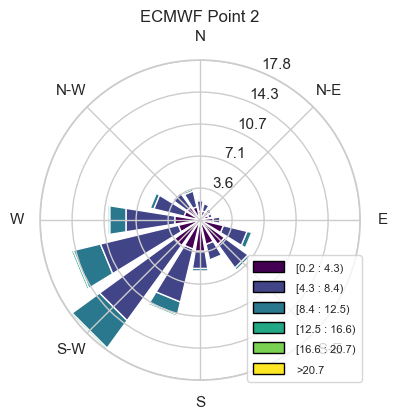

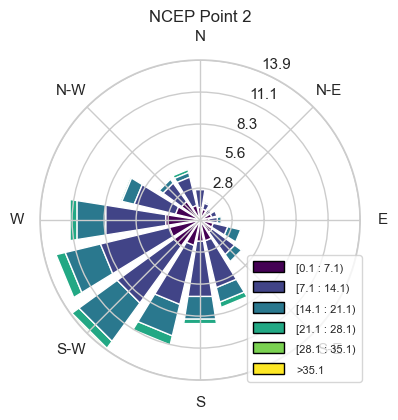

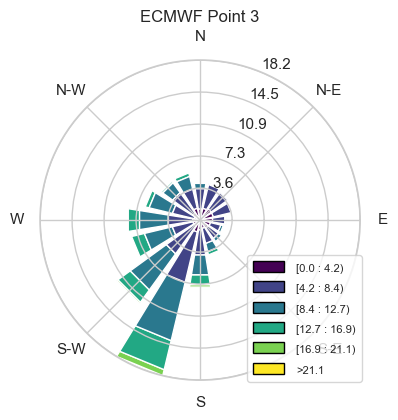

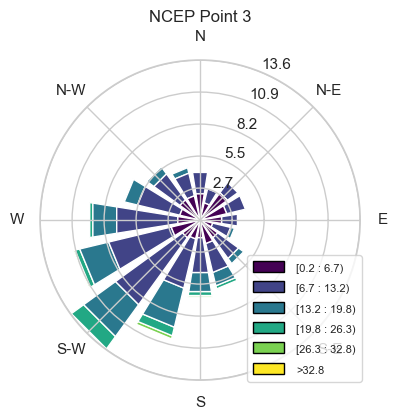

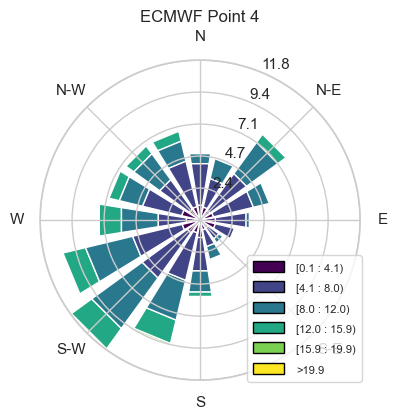

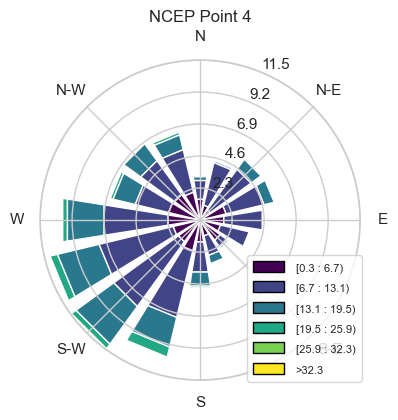

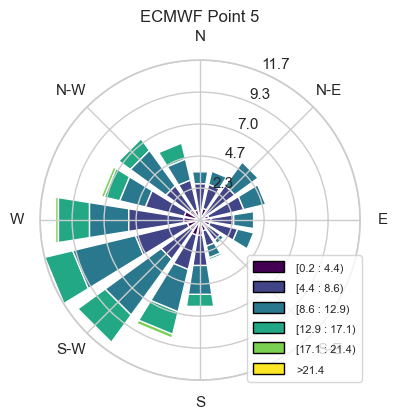

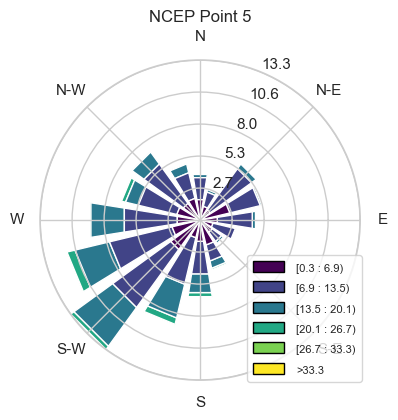

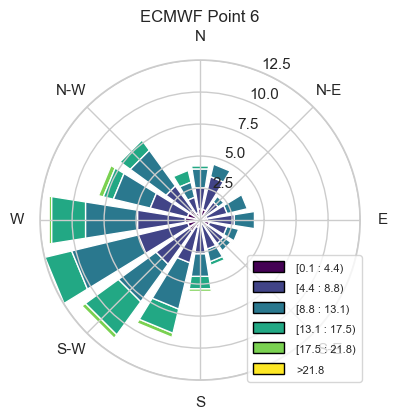

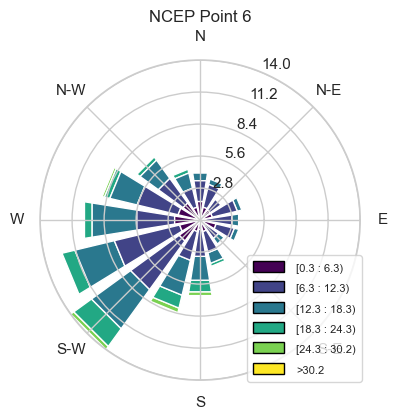

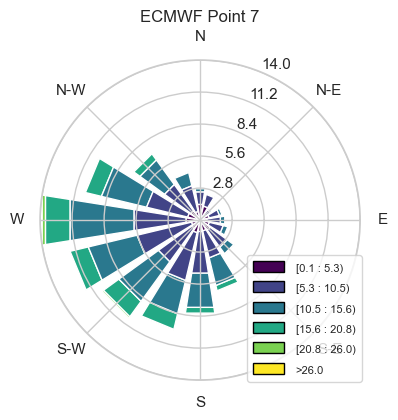

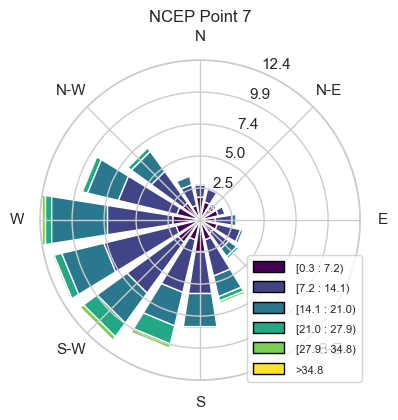

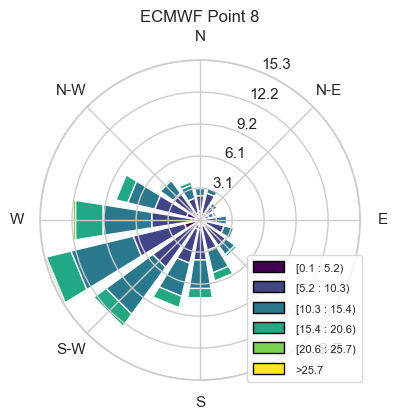

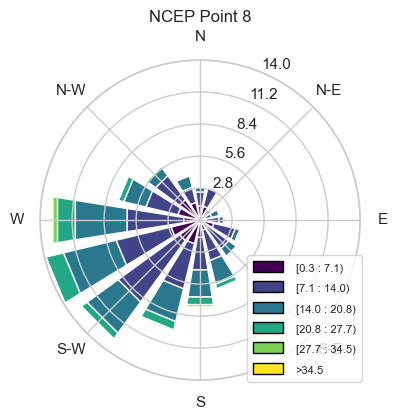

In [8]:
for n in range(0,9):
    ecmwf_wind_speed_row = ecmwf_wind_speed[:,n]
    ecmwf_wind_direction_row = ecmwf_wind_direction[:,n]

    fig = plt.figure(figsize=(8,4))
    sns.set(style="whitegrid")
    ax = WindroseAxes.from_ax(fig=fig)
    ax.bar(ecmwf_wind_direction_row, ecmwf_wind_speed_row, normed=True, opening=0.8, edgecolor='white', cmap=cm.viridis)
    ax.set_legend(loc=4)
    ax.set_title(f"ECMWF Point {n:.0f}")


    ncep_wind_speed_row = ncep_wind_speed[:,n]
    ncep_wind_direction_row = ncep_wind_direction[:,n]

    fig = plt.figure(figsize=(8,4))
    sns.set(style="whitegrid")
    ax = WindroseAxes.from_ax(fig=fig)
    ax.bar(ncep_wind_direction_row, ncep_wind_speed_row, normed=True, opening=0.8, edgecolor='white', cmap=cm.viridis)
    ax.set_legend(loc=4)
    ax.set_title(f"NCEP Point {n:.0f}")

#### Monthly Averages

##### Wind Speed

Text(0.5, 1.01, 'Comparing Monthly Averaged Wind Speeds at 9 Grid Points')

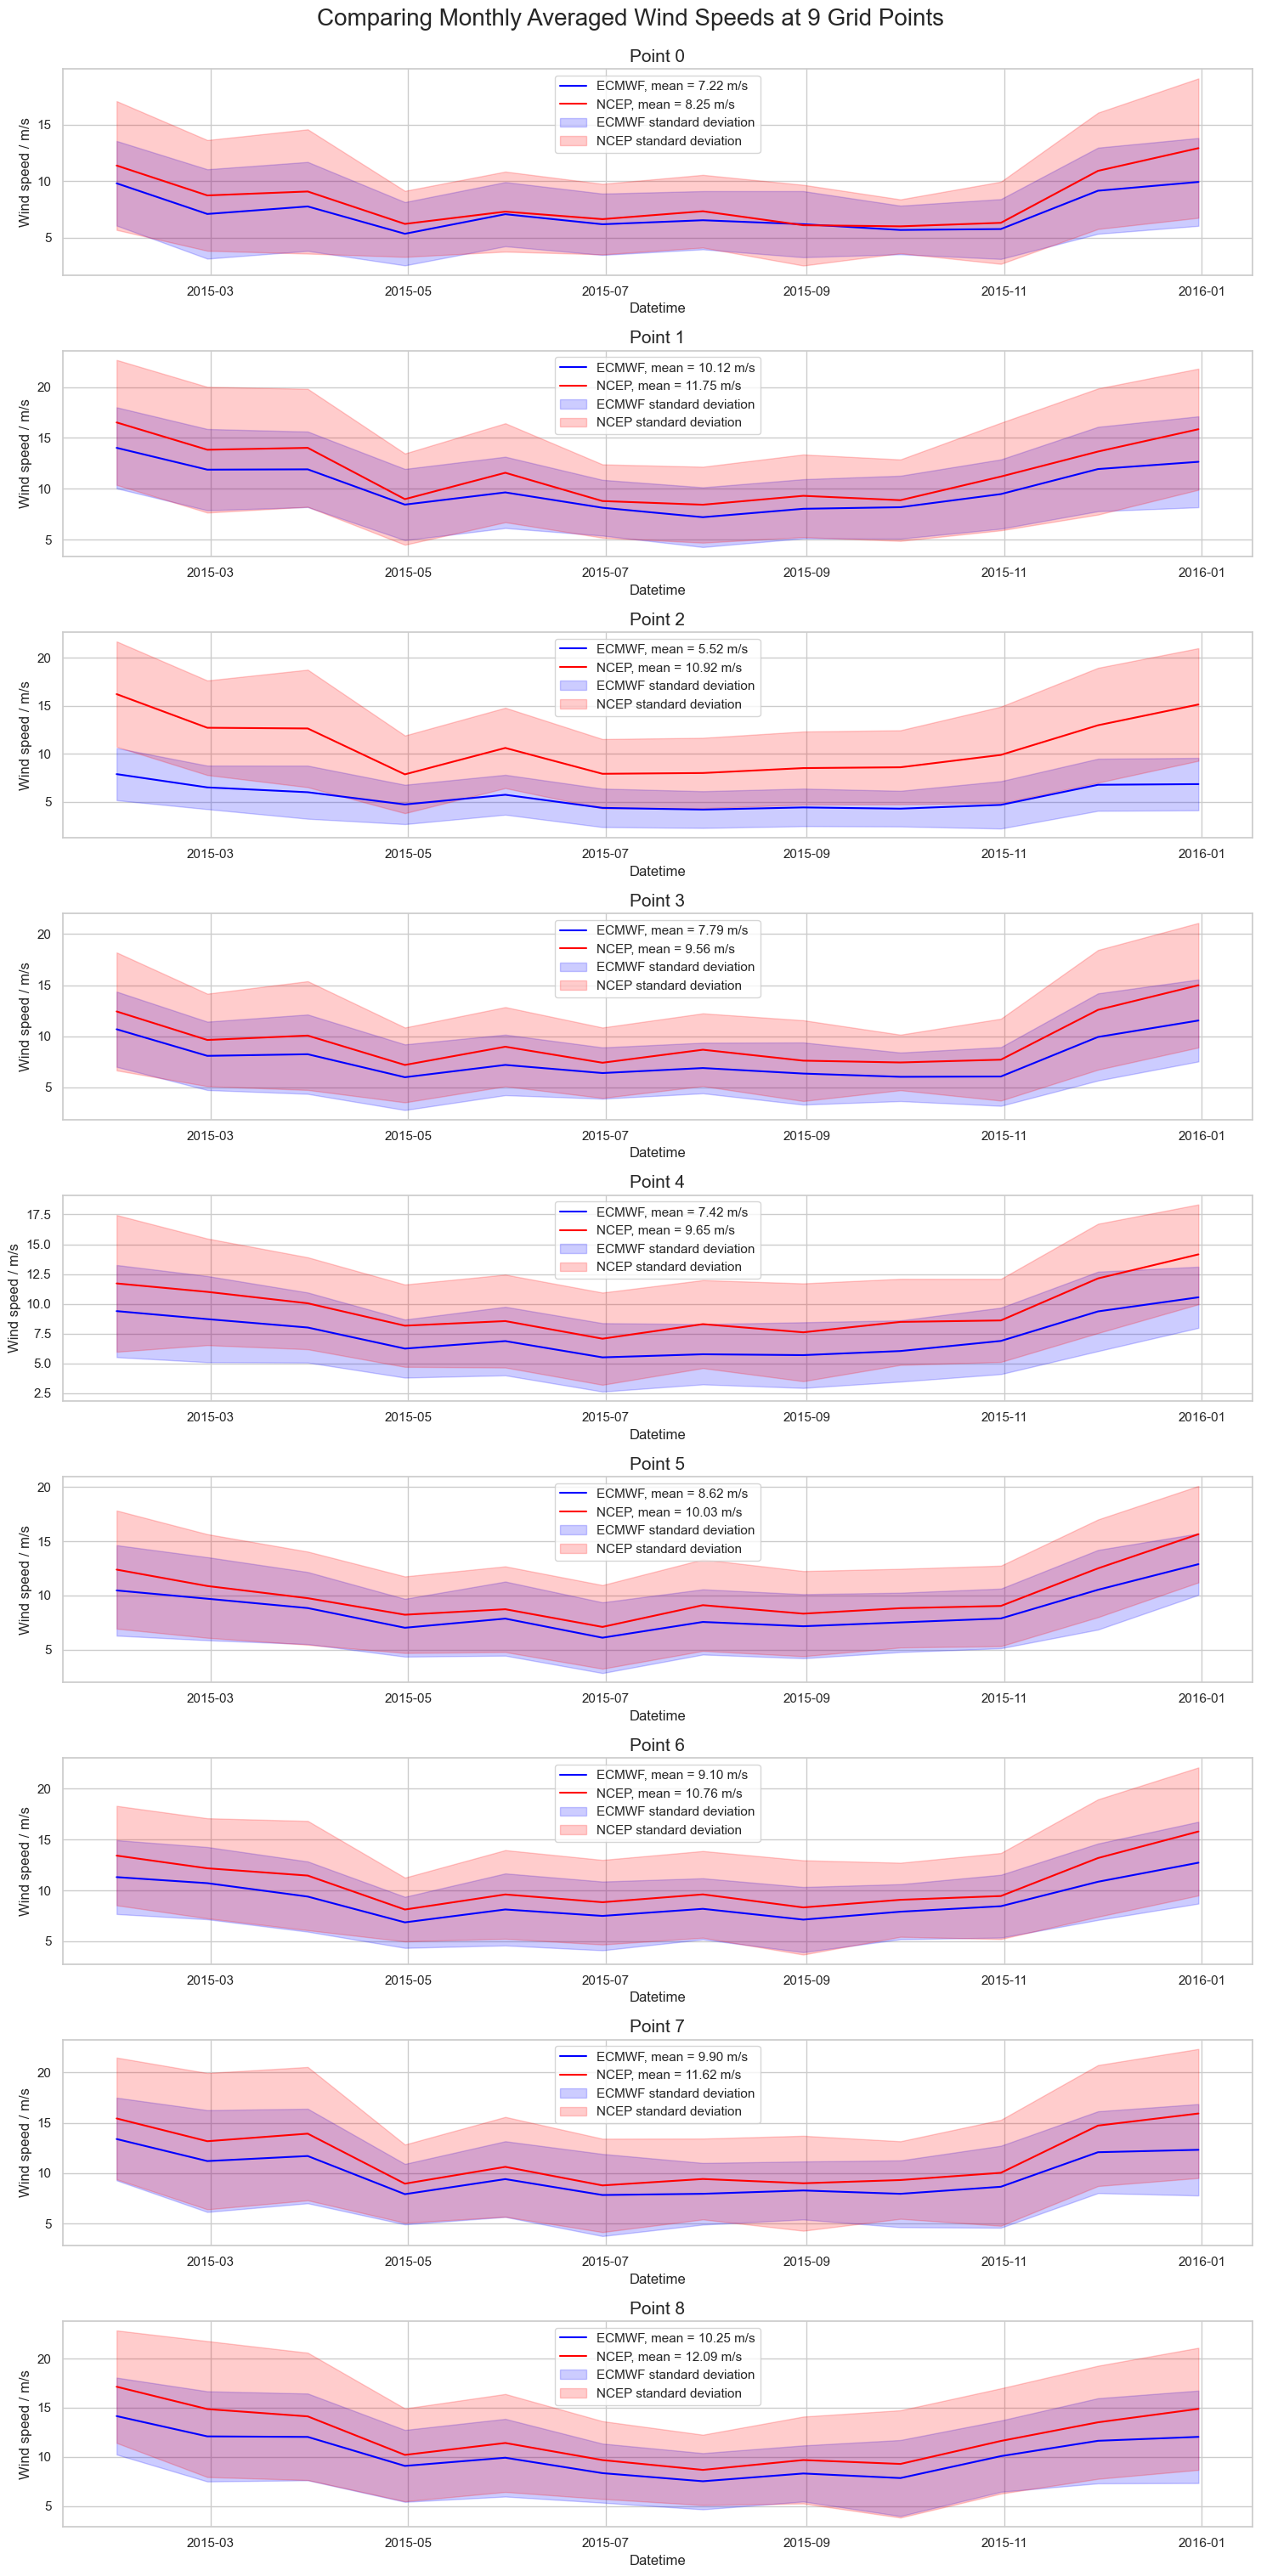

In [12]:
ecmwf_monthly = ecmwf_wind_speed.resample(time='M').mean()
ncep_monthly = ncep_wind_speed.resample(time='M').mean()

ecmwf_std = ecmwf_wind_speed.resample(time='M').std()
ncep_std = ncep_wind_speed.resample(time='M').std()

fig, axs = plt.subplots(9, figsize=(15,30))
sns.set(style="whitegrid")

for n in range(0,9):   
    ecmwf_wind_speed_row = ecmwf_monthly[:,n]
    ncep_wind_speed_row = ncep_monthly[:,n]

    ecmwf_row_std = ecmwf_std[:,n]
    ncep_row_std = ncep_std[:,n]

    axs[n].plot(ecmwf_monthly.indexes['time'], ecmwf_wind_speed_row,
                label=f'ECMWF, mean = {ecmwf_wind_speed_row.values.mean():.2f} m/s', color='blue')

    axs[n].plot(ncep_monthly.indexes['time'], ncep_wind_speed_row,
                label=f'NCEP, mean = {ncep_wind_speed_row.values.mean():.2f} m/s', color='red')
    

    # adding standard deviation shading
    upper_ecmwf = ecmwf_wind_speed_row.values + ecmwf_row_std.values
    lower_ecmwf = ecmwf_wind_speed_row.values - ecmwf_row_std.values

    upper_ncep = ncep_wind_speed_row.values + ncep_row_std.values
    lower_ncep = ncep_wind_speed_row.values - ncep_row_std.values

    axs[n].fill_between(ecmwf_monthly.indexes['time'], lower_ecmwf, upper_ecmwf, color='blue', alpha=0.2, label="ECMWF standard deviation")
    axs[n].fill_between(ncep_monthly.indexes['time'], lower_ncep, upper_ncep, color='red', alpha=0.2, label="NCEP standard deviation")


    axs[n].set_title(f"Point {n:.0f}", fontsize=15)
    axs[n].set_xlabel("Datetime")
    axs[n].set_ylabel("Wind speed / m/s")
    axs[n].legend(loc='upper center')

fig.tight_layout()
fig.suptitle("Comparing Monthly Averaged Wind Speeds at 9 Grid Points", fontsize=20, y=1.01)

##### Wind Direction

Text(0.5, 1.01, 'Comparing Monthly Averaged Wind Directions at 9 Grid Points')

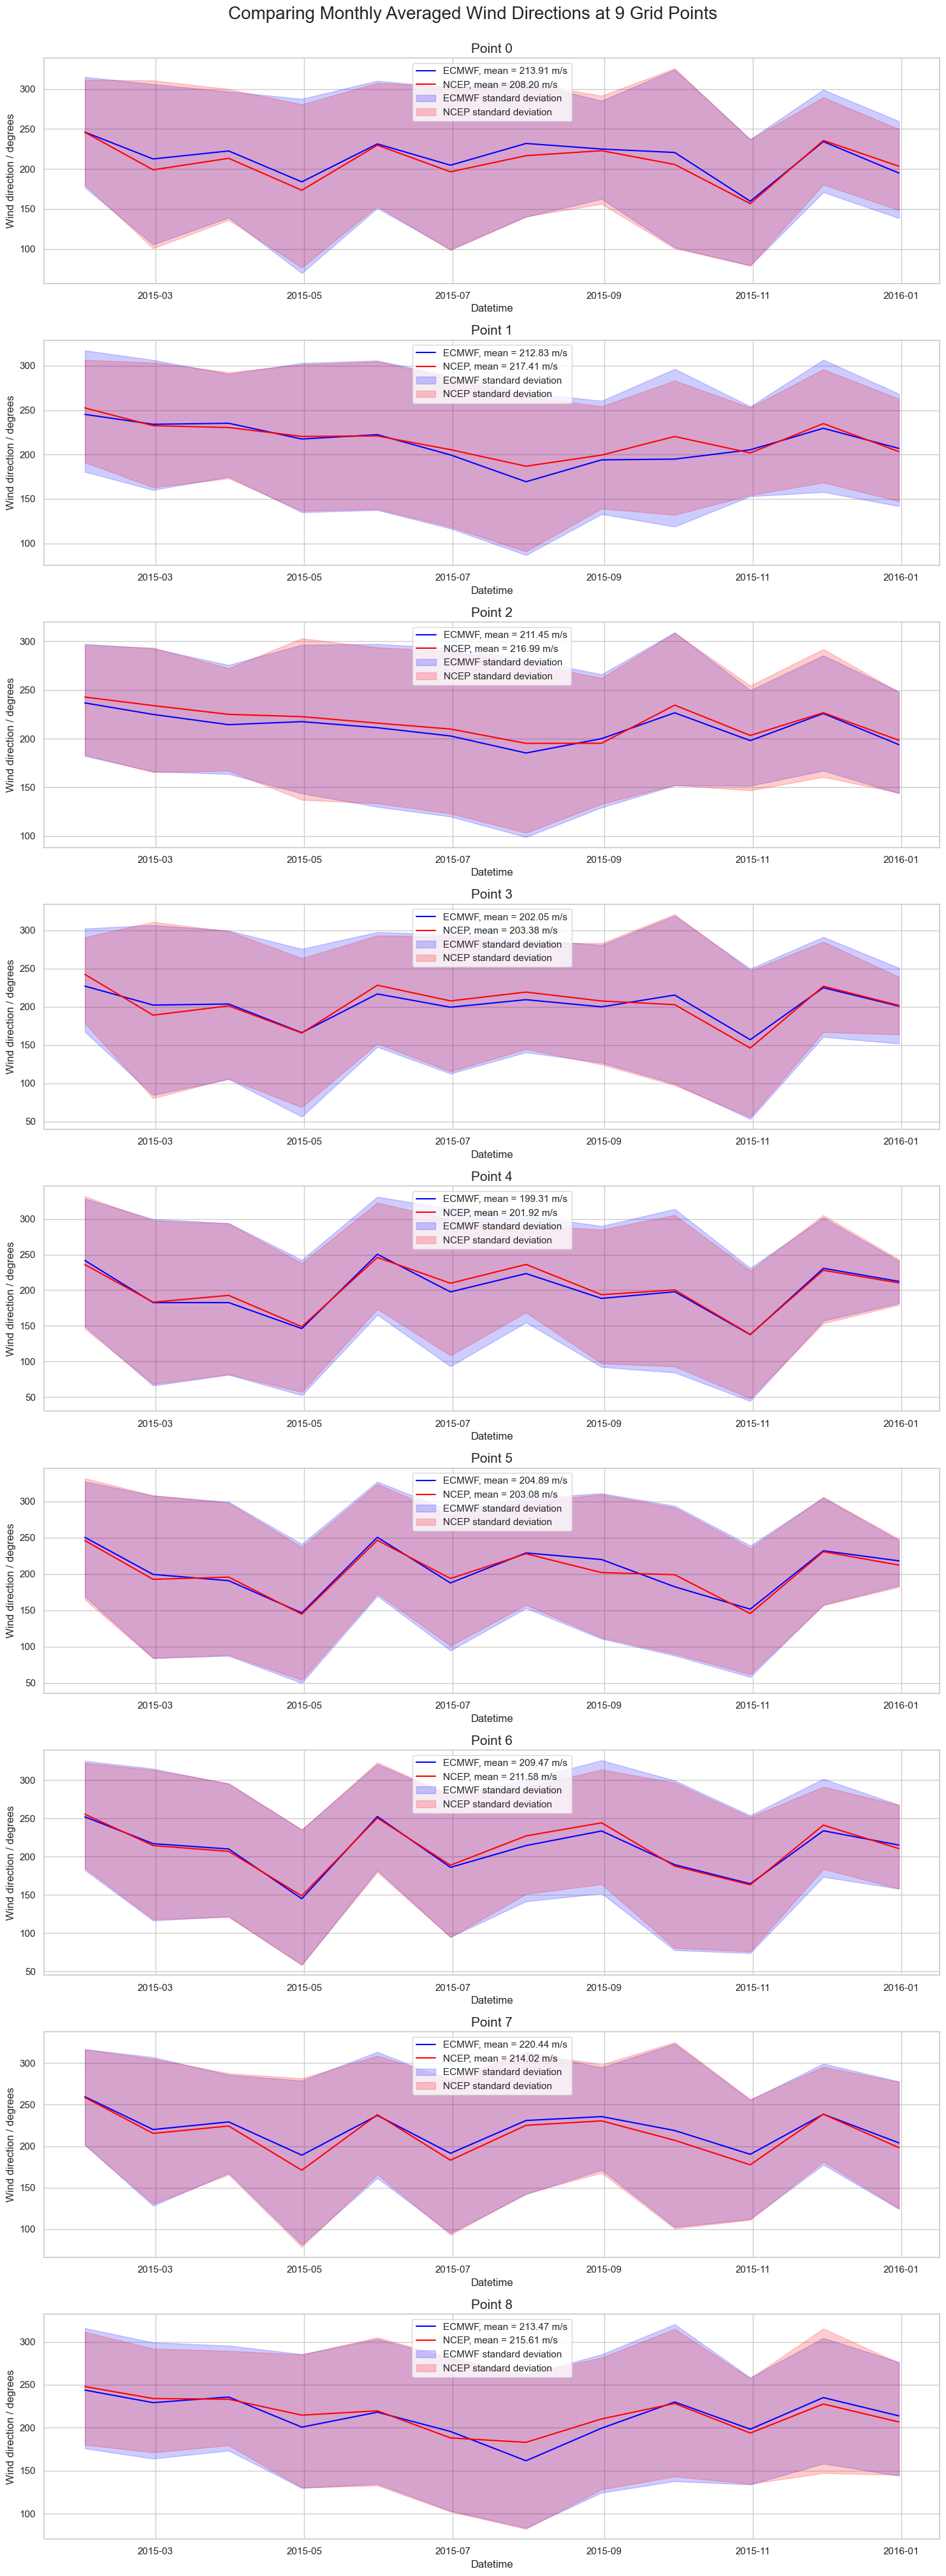

In [13]:
ecmwf_monthly = ecmwf_wind_direction.resample(time='M').mean()
ncep_monthly = ncep_wind_direction.resample(time='M').mean()

ecmwf_std = ecmwf_wind_direction.resample(time='M').std()
ncep_std = ncep_wind_direction.resample(time='M').std()

fig, axs = plt.subplots(9, figsize=(15,40))
sns.set(style="whitegrid")

for n in range(0,9):
    ecmwf_wind_direction_row = ecmwf_monthly[:,n]
    ncep_wind_direction_row = ncep_monthly[:,n]

    ecmwf_row_std = ecmwf_std[:,n]
    ncep_row_std = ncep_std[:,n]

    axs[n].plot(ecmwf_monthly.indexes['time'], ecmwf_wind_direction_row,
                label=f'ECMWF, mean = {ecmwf_wind_direction_row.values.mean():.2f} m/s', color='blue')

    axs[n].plot(ncep_monthly.indexes['time'], ncep_wind_direction_row,
                label=f'NCEP, mean = {ncep_wind_direction_row.values.mean():.2f} m/s', color='red')
    

    upper_ecmwf = ecmwf_wind_direction_row.values + ecmwf_row_std.values
    lower_ecmwf = ncep_wind_direction_row.values - ecmwf_row_std.values

    upper_ncep = ecmwf_wind_direction_row.values + ncep_row_std.values
    lower_ncep = ncep_wind_direction_row.values - ncep_row_std.values

    axs[n].fill_between(ecmwf_monthly.indexes['time'], lower_ecmwf, upper_ecmwf, color='blue', alpha=0.2, label="ECMWF standard deviation")
    axs[n].fill_between(ncep_monthly.indexes['time'], lower_ncep, upper_ncep, color='red', alpha=0.2, label="NCEP standard deviation")
    
    
    axs[n].set_title(f"Point {n:.0f}", fontsize=15)
    axs[n].set_xlabel("Datetime")
    axs[n].set_ylabel("Wind direction / degrees")
    axs[n].legend(loc='upper center')

fig.tight_layout()
fig.suptitle("Comparing Monthly Averaged Wind Directions at 9 Grid Points", fontsize=20, y=1.01)

#### Comparing Point Averages

Text(0.5, 1.02, 'Comparing Mean Wind Speeds and Directions at 9 Grid Points for 2015')

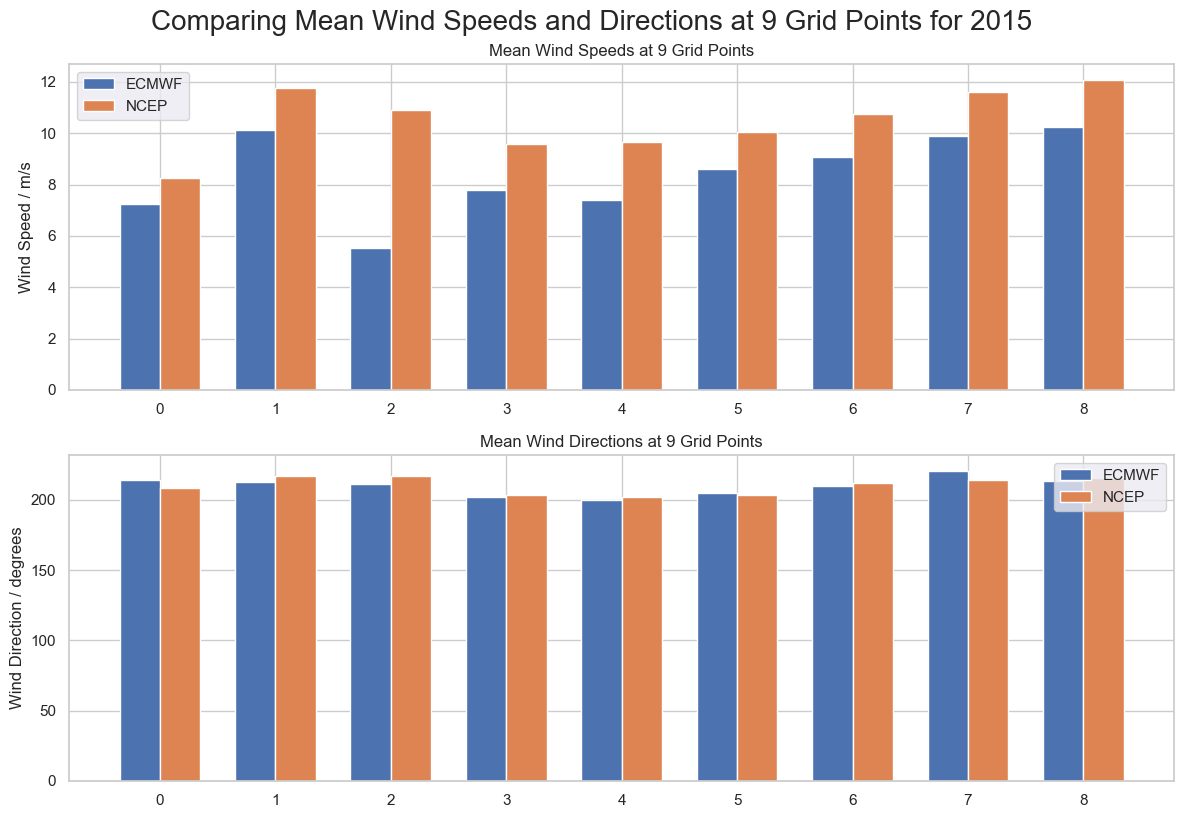

In [14]:
ecmwf_wind_means = []
ncep_wind_means = []
ncep_direction_means = []
ecmwf_direction_means = []
points = np.linspace(0,8,9)

for n in range(9):
    ecmwf_wind_speed_row = ecmwf_wind_speed[:,n]
    ecmwf_wind_direction_row = ecmwf_wind_direction[:,n]
    ncep_wind_speed_row = ncep_wind_speed[:,n]
    ncep_wind_direction_row = ncep_wind_direction[:,n]

    ecmwf_wind_means.append(ecmwf_wind_speed_row.values.mean())
    ecmwf_direction_means.append(ecmwf_wind_direction_row.values.mean())
    ncep_wind_means.append(ncep_wind_speed_row.values.mean())
    ncep_direction_means.append(ncep_wind_direction_row.values.mean())


fig, ax = plt.subplots(2,1, figsize=(12, 8))
sns.set(style="darkgrid")

bar_width = 0.35

bar1 = ax[0].bar(points - bar_width / 2, ecmwf_wind_means, bar_width, label='ECMWF')
bar2 = ax[0].bar(points + bar_width / 2, ncep_wind_means, bar_width, label='NCEP')

bar3 = ax[1].bar(points - bar_width / 2, ecmwf_direction_means, bar_width, label='ECMWF')
bar4 = ax[1].bar(points + bar_width / 2, ncep_direction_means, bar_width, label='NCEP')

ax[0].set_ylabel('Wind Speed / m/s')
ax[0].set_title('Mean Wind Speeds at 9 Grid Points', fontsize=12)
ax[0].set_xticks(points)
ax[0].set_xticklabels(map(int, points))
ax[0].legend()

ax[1].set_ylabel('Wind Direction / degrees')
ax[1].set_title('Mean Wind Directions at 9 Grid Points', fontsize=12)
ax[1].set_xticks(points)
ax[1].set_xticklabels(map(int, points))
ax[1].legend()

fig.tight_layout()
fig.suptitle("Comparing Mean Wind Speeds and Directions at 9 Grid Points for 2015", fontsize=20, y=1.02)

#### Exploring Interpolation

There seems to be a consistent drop in wind speeds when comparing the NCEP dataset to ECMWF. One possible explanation of this is as a result of the interpolation.

Closest latitude and longitude to MHD site in NCEP dataset: 52.38, -9.38
Closest latitude and longitude to MHD site in ECMWF dataset: 53.33, -9.90


c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\cartopy\mpl\geoaxes.py:1696: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)


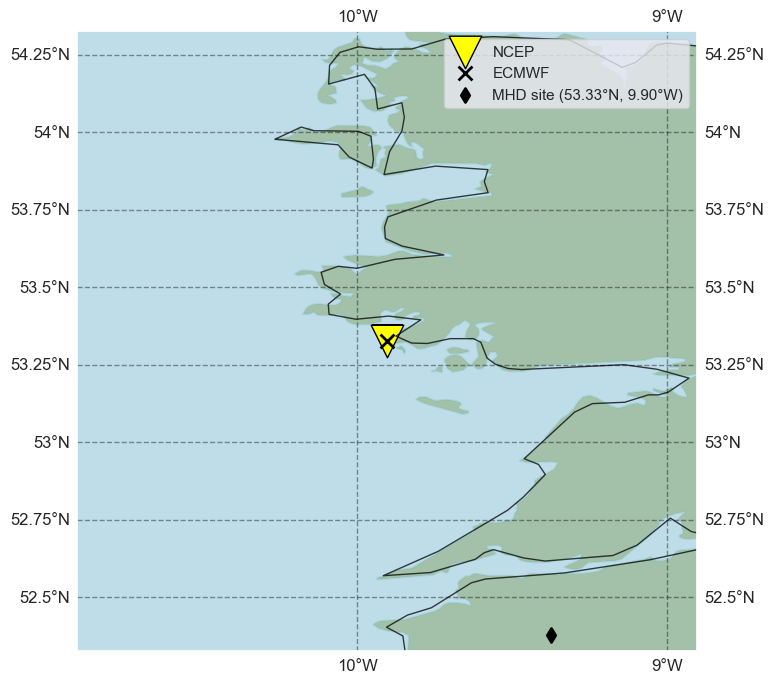

In [31]:
# finding the closest latitude and longitude to the MHD site
closest_lat_ncep, closest_lon_ncep = f.find_closest_lat_lon(site_coords, ncep_original)
closest_lat_ecmwf, closest_lon_ecmwf = f.find_closest_lat_lon(site_coords, ecmwf_original)
print(f"Closest latitude and longitude to MHD site in NCEP dataset: {closest_lat_ncep:.2f}, {closest_lon_ncep:.2f}")
print(f"Closest latitude and longitude to MHD site in ECMWF dataset: {closest_lat_ecmwf:.2f}, {closest_lon_ecmwf:.2f}")

# plotting closest latitude and longitude to MHD site
fig, ax = plt.subplots(figsize=(8, 15), subplot_kw={'projection':cartopy.crs.PlateCarree()})
sns.set(style='darkgrid')
sns.set_palette('colorblind')

ax.coastlines(resolution='50m', color='black', linewidth=1, alpha=0.75)
ax.add_feature(cfeature.LAND, color='darkgreen', alpha=0.3)
ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.7)

# plotting coordinates on grid
# desired coordinate
ax.scatter(site_coords[1], site_coords[0], s=550, color='yellow', marker='v', label='NCEP', 
           alpha=1, edgecolor='black')

# ECMWF closest point
ax.scatter(closest_lon_ecmwf, closest_lat_ecmwf, transform=cartopy.crs.PlateCarree(),
              s=100, color='black', marker='x', linewidth=2, zorder=10, edgecolor='black', label='ECMWF')

# NCEP closest point
ax.scatter(closest_lon_ncep, closest_lat_ncep, transform=cartopy.crs.PlateCarree(), 
           s=50, color='black', marker='d', linewidth=2, zorder=10, edgecolor='black', label=f'MHD site ({site_coords[0]:.2f}°N, {abs(site_coords[1]):.2f}°W)')


ax.set_xlim(site_coords[1] - 1, site_coords[1] + 1)
ax.set_ylim(site_coords[0] - 1, site_coords[0] + 1)

# add gridlines
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.4, linestyle='--')

# reducing number of gridlines
# installing mticker
import matplotlib.ticker as mticker

gl.xlocator = mticker.FixedLocator(np.arange(-10, 10, 1))


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
# ax.set_title('Closest Latitude and Longitude to MHD Site in NCEP and ECMWF Datasets')

In [18]:
# calculating the nearest latitude and longitude values in the NCEP and ECMWF datasets to each of the 9 grid points
points_lat = np.array([0, 5, 5, 0, -5, -5, -5, 0, 5]) + site_coords[0]
points_lon = np.array([0, 0, 5, 5, 5, 0, -5, -5, -5]) + site_coords[1]

closest_lats_ncep = []
closest_lons_ncep = []

closest_lats_ecmwf = []
closest_lons_ecmwf = []

for points in range(0,9):
    point_coords = (points_lat[points], points_lon[points])
    # print(f"Point {points} coordinates: {point_coords}")

    closest_lat_ncep, closest_lon_ncep = f.find_closest_lat_lon(point_coords, ncep_original)
    closest_lats_ncep.append(closest_lat_ncep)
    closest_lons_ncep.append(closest_lon_ncep)

    closest_lat_ecmwf, closest_lon_ecmwf = f.find_closest_lat_lon(point_coords, ecmwf_original)
    closest_lats_ecmwf.append(closest_lat_ecmwf)
    closest_lons_ecmwf.append(closest_lon_ecmwf)

    # print(f"NCEP closest point: {closest_lat_ncep:.2f}, {closest_lon_ncep:.2f}")
    # print(f"ECMWF closest point: {closest_lat_ecmwf:.2f}, {closest_lon_ecmwf:.2f}")

In [19]:
# putting the closest latitude and longitude values into a dataframe
closest_points_df = pd.DataFrame({'Point': np.arange(0, 9), 'Point Latitude': points_lat, 'Point Longitude': points_lon,
                                  'NCEP Closest Latitude': closest_lats_ncep, 'NCEP Closest Longitude': closest_lons_ncep, 
                                  'ECMWF Closest Latitude': closest_lats_ecmwf, 'ECMWF Closest Longitude': closest_lons_ecmwf})

closest_points_df.set_index('Point', inplace=True)

closest_points_df

,Point Latitude,Point Longitude,NCEP Closest Latitude,NCEP Closest Longitude,ECMWF Closest Latitude,ECMWF Closest Longitude
Point,,,,,,
0,53.3267,-9.9046,52.3799,-9.375,53.327,-9.9045
1,58.3267,-9.9046,58.0939,-9.375,58.327,-9.9045
2,58.3267,-4.9046,58.0939,-5.625,58.327,-4.9042916
3,53.3267,-4.9046,52.3799,-5.625,53.327,-4.9042916
4,48.3267,-4.9046,48.5705,-5.625,48.327,-4.9042916
5,48.3267,-9.9046,48.5705,-9.375,48.327,-9.9045
6,48.3267,-14.9046,48.5705,-15.0,48.327,-14.904708
7,53.3267,-14.9046,52.3799,-15.0,53.327,-14.904708
8,58.3267,-14.9046,58.0939,-15.0,58.327,-14.904708


In [20]:
ncep_land_sea = ['land', 'sea', 'sea', 'sea', 'sea', 'sea', 'sea', 'sea', 'sea']
ecmwf_land_sea = ['land', 'sea', 'land', 'sea', 'sea', 'sea', 'sea', 'sea', 'sea']

closest_points_df['NCEP Land/Sea'] = ncep_land_sea
closest_points_df[' ECMWF Land/Sea'] = ecmwf_land_sea

closest_points_df

,Point Latitude,Point Longitude,NCEP Closest Latitude,NCEP Closest Longitude,ECMWF Closest Latitude,ECMWF Closest Longitude,NCEP Land/Sea,ECMWF Land/Sea
Point,,,,,,,,
0,53.3267,-9.9046,52.3799,-9.375,53.327,-9.9045,land,land
1,58.3267,-9.9046,58.0939,-9.375,58.327,-9.9045,sea,sea
2,58.3267,-4.9046,58.0939,-5.625,58.327,-4.9042916,sea,land
3,53.3267,-4.9046,52.3799,-5.625,53.327,-4.9042916,sea,sea
4,48.3267,-4.9046,48.5705,-5.625,48.327,-4.9042916,sea,sea
5,48.3267,-9.9046,48.5705,-9.375,48.327,-9.9045,sea,sea
6,48.3267,-14.9046,48.5705,-15.0,48.327,-14.904708,sea,sea
7,53.3267,-14.9046,52.3799,-15.0,53.327,-14.904708,sea,sea
8,58.3267,-14.9046,58.0939,-15.0,58.327,-14.904708,sea,sea


The two datasets have different datapoints that they're interpolating from, which may explain some of the discrepancy seen. The land/sea check was to test a hypothesis; wind speeds tend to be higher over sea so it was thought that interpolating from points with different environments may cause a difference. 

The point where the biggest drop in wind speed from NCEP to ECWMF seen is point 2 (see monthly average plots). The closest point to the desired coordinate in the ECMWF dataset is indeed above land, which might account for the observed difference.

In [21]:
point2_lat = closest_points_df['Point Latitude'][2]
point2_lon = closest_points_df['Point Longitude'][2]

point2_ncep_lat = closest_points_df['NCEP Closest Latitude'][2]
point2_ncep_lon = closest_points_df['NCEP Closest Longitude'][2]

point2_ecmwf_lat = closest_points_df['ECMWF Closest Latitude'][2]
point2_ecmwf_lon = closest_points_df['ECMWF Closest Longitude'][2]

point2_limits = [point2_lon - 2, point2_lon + 2, point2_lat - 2, point2_lat + 2]

c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\cartopy\mpl\geoaxes.py:1696: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)


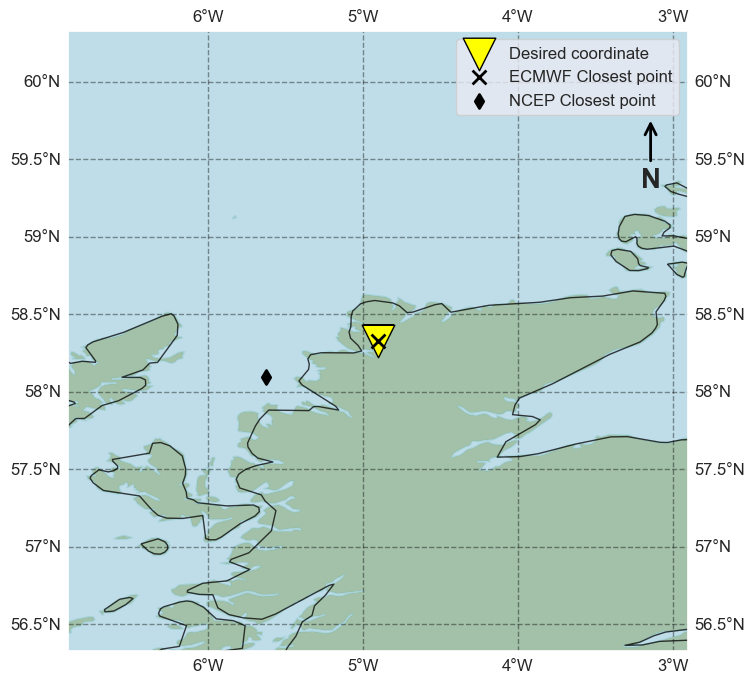

In [22]:
# plotting the closest latitude and longitude values to the MHD site with cartopy

# plotting grid points on map
fig, ax = plt.subplots(figsize=(8,15), subplot_kw={'projection':cartopy.crs.PlateCarree()})
img_extent = (point2_limits[0], point2_limits[1], point2_limits[2], point2_limits[3])
ax.set_extent(img_extent)

ax.coastlines(resolution='50m', color='black', linewidth=1, alpha=0.75)
ax.add_feature(cfeature.LAND, color='darkgreen', alpha=0.3)
ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.7)

# desired coordinate
ax.scatter(point2_lon, point2_lat, s=550, color='yellow', marker='v', label="Desired coordinate", 
           alpha=1, edgecolor='black')

# ECMWF closest point
ax.scatter(point2_ecmwf_lon, point2_ecmwf_lat, transform=cartopy.crs.PlateCarree(),
              s=100, color='black', marker='x', linewidth=2, zorder=10, edgecolor='black', label="ECMWF Closest point")

# NCEP closest point
ax.scatter(point2_ncep_lon, point2_ncep_lat, transform=cartopy.crs.PlateCarree(), 
           s=50, color='black', marker='d', linewidth=2, zorder=10, edgecolor='black', label="NCEP Closest point")



ax.legend(loc="upper right", fontsize=12)

# add a north arrow
arrow_props = dict(facecolor='black', arrowstyle='->', edgecolor='black', linewidth=2)

ax.annotate('N', xy=(0.94, 0.86), xycoords='axes fraction', size=20, weight='bold',
            xytext=(0.94, 0.76), textcoords='axes fraction',
            arrowprops=arrow_props,
            horizontalalignment='center', verticalalignment='center')


# add gridlines
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.4, linestyle='--')

# reducing number of gridlines
# installing mticker
import matplotlib.ticker as mticker

gl.xlocator = mticker.FixedLocator(np.arange(-10, 10, 1))

plt.show()